In [399]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from linearmodels import PooledOLS
from linearmodels.panel import RandomEffects, PanelOLS
from scipy.stats import f, t
import numpy as np
from scipy.stats import chi2
import warnings
warnings.filterwarnings('ignore')

In [400]:
!pip install linearmodels

#**Загрузка и подготовка данных**

Government expenditure on education, total (% of government expenditure) - Общие государственные расходы на образование (текущие, капитальные и трансфертные) выражаются в процентах от общих государственных расходов во всех секторах (включая здравоохранение, образование, социальные услуги и т.д.). Он включает в себя расходы, финансируемые за счет трансфертов из международных источников правительству. Под общим правительством обычно понимаются местные, региональные и центральные органы власти.    

Literacy rate, adult total (% of people ages 15 and above) - Уровень грамотности взрослого населения – это процент людей в возрасте 15 лет и старше, которые умеют читать и писать, понимая короткое простое высказывание о своей повседневной жизни.    

GDP growth (annual %) - Годовой процентный темп роста ВВП в рыночных ценах на основе постоянной местной валюты    

Life expectancy at birth, total (years) - Ожидаемая продолжительность жизни при рождении показывает, сколько лет прожил бы новорожденный, если бы преобладающая структура смертности на момент его рождения оставалась неизменной на протяжении всей его жизни.    

Domestic general government health expenditure (% of general government expenditure) - Государственные расходы на здравоохранение из внутренних источников в процентах от общих государственных расходов.

Control of Corruption: Estimate - Контроль над коррупцией отражает представление о том, в какой степени государственная власть используется для личной выгоды, включая как мелкие, так и крупные формы коррупции, а также «захват» государства элитами и частными интересами    

Urban population (% of total population) - относится к людям, проживающим в городских районах    

Unemployment, total (% of total labor force) (national estimate - Безработица относится к доле рабочей силы, которая не имеет работы, но доступна для трудоустройства и ищет ее. Определения рабочей силы и безработицы различаются в зависимости от страны.

In [427]:
df = pd.read_excel('P_Data_Extract_From_World_Development_Indicators (1).xlsx')

In [428]:
df.head(3)

,Country Name,Country Code,Series Name,Series Code,2023 [YR2023],2022 [YR2022],2021 [YR2021],2020 [YR2020],2019 [YR2019],2018 [YR2018],2017 [YR2017],2016 [YR2016],2015 [YR2015],2014 [YR2014],2013 [YR2013],2012 [YR2012],2011 [YR2011],2010 [YR2010],2009 [YR2009]
0,Germany,DEU,"Government expenditure on education, total (% ...",SE.XPD.TOTL.GB.ZS,..,9.190701,9.066173,9.298441,9.726378,9.638202,9.480731,9.47783,9.638144,9.748104,9.709711,9.51723,9.511645,9.113441,9.018068
1,Germany,DEU,Control of Corruption: Estimate,CC.EST,..,1.818376,1.783172,1.825714,1.865366,1.898325,1.796618,1.781451,1.776124,1.812497,1.797944,1.81763,1.74195,1.766429,1.74621
2,Germany,DEU,Urban population (% of total population),SP.URB.TOTL.IN.ZS,..,77.648,77.544,77.453,77.376,77.312,77.261,77.224,77.2,77.19,77.18,77.17,77.16,76.966,76.771


In [429]:
df_long = df.melt(id_vars=["Country Name", "Country Code", "Series Name", "Series Code"],
                  var_name="Time",
                  value_name="Value")
df_long["Time Code"] = df_long["Time"].str.extract(r'(\d{4})')[0]
df_long["Time"] = df_long["Time Code"].apply(lambda x: f"YR{x}")
df_long['Value'] = pd.to_numeric(df_long['Value'].replace('..', pd.NA))

df_pivot = df_long.pivot_table(index=["Country Name", "Country Code", "Time", "Time Code"],
                               columns="Series Name",
                               values="Value",
                               aggfunc='first').reset_index()

df_pivot.columns = [f"{col[0]}" if col[1] == '' else f"{col[1]}" for col in df_pivot.columns]

df_pivot.columns = [
    "Country Name", "Country Code", "Time", "Time Code",
    "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]",
    "Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]",
    "Life expectancy at birth, total (years) [SP.DYN.LE00.IN]",
    "Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]",
    "Control of Corruption: Estimate [CC.EST]",
    "Urban population (% of total population) [SP.URB.TOTL.IN.ZS]",
    "Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]",
    "Domestic general government health expenditure (% of general government expenditure) [SH.XPD.GHED.GE.ZS]"

]

df_pivot = df_pivot[[
    "Time", "Time Code", "Country Name", "Country Code",
    "GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]",
    "Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]",
    "Life expectancy at birth, total (years) [SP.DYN.LE00.IN]",
    "Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]",
    "Control of Corruption: Estimate [CC.EST]",
    "Urban population (% of total population) [SP.URB.TOTL.IN.ZS]",
    "Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]",
    "Domestic general government health expenditure (% of general government expenditure) [SH.XPD.GHED.GE.ZS]"
]]
df_pivot.head(5)

,Time,Time Code,Country Name,Country Code,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],"Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]","Life expectancy at birth, total (years) [SP.DYN.LE00.IN]","Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]",Control of Corruption: Estimate [CC.EST],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],"Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]",Domestic general government health expenditure (% of general government expenditure) [SH.XPD.GHED.GE.ZS]
0,YR2009,2009,China,CHN,-0.519457,8.375232,9.398726,13.513532,75.343,NaN,4.30,47.880
1,YR2010,2010,China,CHN,-0.570010,8.750922,10.635871,13.552069,75.599,95.124481,4.10,49.226
2,YR2011,2011,China,CHN,-0.514728,8.602850,9.550832,13.078095,75.903,NaN,4.10,50.511
3,YR2012,2012,China,CHN,-0.438276,9.037293,7.863736,14.407168,76.192,NaN,4.10,51.765
4,YR2013,2013,China,CHN,-0.355790,9.416842,7.766150,13.315405,76.452,NaN,4.05,53.013


In [430]:
df_pivot.drop(['Time','Country Code'],axis = 1, inplace = True)

In [431]:
df_pivot.head(5)

,Time Code,Country Name,GDP growth (annual %) [NY.GDP.MKTP.KD.ZG],"Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]","Life expectancy at birth, total (years) [SP.DYN.LE00.IN]","Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]",Control of Corruption: Estimate [CC.EST],Urban population (% of total population) [SP.URB.TOTL.IN.ZS],"Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]",Domestic general government health expenditure (% of general government expenditure) [SH.XPD.GHED.GE.ZS]
0,2009,China,-0.519457,8.375232,9.398726,13.513532,75.343,NaN,4.30,47.880
1,2010,China,-0.570010,8.750922,10.635871,13.552069,75.599,95.124481,4.10,49.226
2,2011,China,-0.514728,8.602850,9.550832,13.078095,75.903,NaN,4.10,50.511
3,2012,China,-0.438276,9.037293,7.863736,14.407168,76.192,NaN,4.10,51.765
4,2013,China,-0.355790,9.416842,7.766150,13.315405,76.452,NaN,4.05,53.013


In [432]:
df_pivot.isna().sum()

Time Code                                                                                                    0
Country Name                                                                                                 0
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                                                                    3
Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]                 8
Life expectancy at birth, total (years) [SP.DYN.LE00.IN]                                                     3
Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]                                  8
Control of Corruption: Estimate [CC.EST]                                                                     3
Urban population (% of total population) [SP.URB.TOTL.IN.ZS]                                                69
Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]                         3
D

In [433]:
df_pivot.dtypes

Time Code                                                                                                    object
Country Name                                                                                                 object
GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]                                                                   float64
Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]                float64
Life expectancy at birth, total (years) [SP.DYN.LE00.IN]                                                    float64
Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]                                 float64
Control of Corruption: Estimate [CC.EST]                                                                    float64
Urban population (% of total population) [SP.URB.TOTL.IN.ZS]                                                float64
Unemployment, total (% of total labor force) (national estimate) [SL.UEM

In [434]:
df_pivot.rename(columns = {'Government expenditure on education, total (% of government expenditure) [SE.XPD.TOTL.GB.ZS]': 'exp_educ',
                     'Control of Corruption: Estimate [CC.EST]': 'control_cor',
                     'Literacy rate, adult total (% of people ages 15 and above) [SE.ADT.LITR.ZS]': 'literacy_rate',
                     'GDP growth (annual %) [NY.GDP.MKTP.KD.ZG]': 'GDP',
                     'Life expectancy at birth, total (years) [SP.DYN.LE00.IN]': 'life_expectancy',
                           'Urban population (% of total population) [SP.URB.TOTL.IN.ZS]' : 'urban',
                           'Unemployment, total (% of total labor force) (national estimate) [SL.UEM.TOTL.NE.ZS]' : 'unemployment',
                           'Domestic general government health expenditure (% of general government expenditure) [SH.XPD.GHED.GE.ZS]': 'health_exp',
                     'Time Code': 'Year', 'Country Name': 'Country'}, inplace = True)
df_pivot.head(3)

,Year,Country,GDP,exp_educ,life_expectancy,literacy_rate,control_cor,urban,unemployment,health_exp
0,2009,China,-0.519457,8.375232,9.398726,13.513532,75.343,NaN,4.3,47.880
1,2010,China,-0.570010,8.750922,10.635871,13.552069,75.599,95.124481,4.1,49.226
2,2011,China,-0.514728,8.602850,9.550832,13.078095,75.903,NaN,4.1,50.511


In [435]:
df_pivot.set_index(['Country', 'Year'], inplace = True)

In [436]:
df_pivot.isna().sum()

GDP                 3
exp_educ            8
life_expectancy     3
literacy_rate       8
control_cor         3
urban              69
unemployment        3
health_exp          3
dtype: int64

In [437]:
df_pivot.drop(['urban'],axis=1,inplace=True) #Удаляем так как имеет много пропусков

In [438]:
# заменим пропуски
df_pivot.interpolate(axis = 0, inplace = True)

In [439]:
#сортируем данные по стране
df_pivot.sort_values(by = ['Country', 'Year'], ascending=True, inplace = True)

In [440]:
df_pivot.head(7)

GDP  exp_educ  life_expectancy  literacy_rate  control_cor  \
Country Year                                                                    
China   2009 -0.519457  8.375232         9.398726      13.513532       75.343   
        2010 -0.570010  8.750922        10.635871      13.552069       75.599   
        2011 -0.514728  8.602850         9.550832      13.078095       75.903   
        2012 -0.438276  9.037293         7.863736      14.407168       76.192   
        2013 -0.355790  9.416842         7.766150      13.315405       76.452   
        2014 -0.337421  9.660886         7.425764      12.752611       76.717   
        2015 -0.299674  9.419024         7.041329      12.259830       76.977   

              unemployment  health_exp  
Country Year                            
China   2009      4.300000      47.880  
        2010      4.100000      49.226  
        2011      4.100000      50.511  
        2012      4.100000      51.765  
        2013      4.050000      53.013  
        2014      4.100000      54.259  
        2015      4.033333      55.500

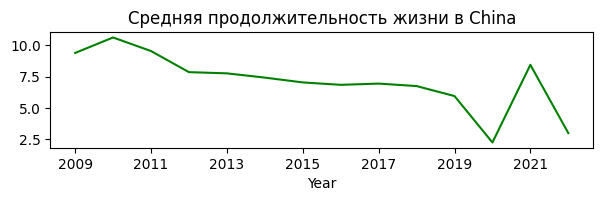

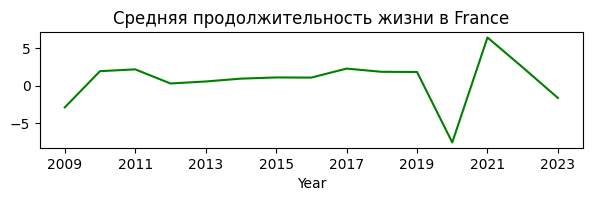

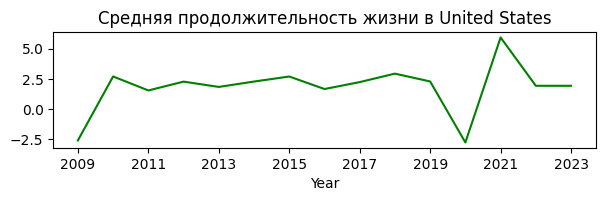

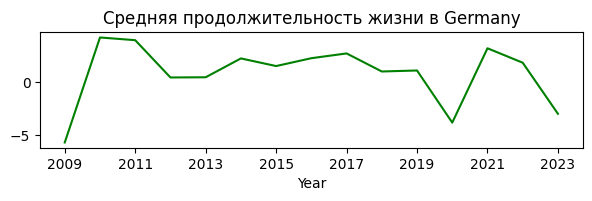

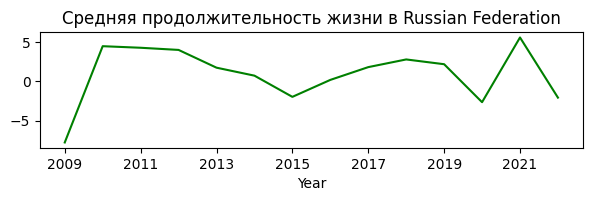

In [441]:
countries = ['China','France','United States','Germany', 'Russian Federation']
for country in countries:
  fig, ax = plt.subplots(figsize = (7,1.5))
  df_pivot['life_expectancy'].loc[country].plot(kind = 'line', color = 'g')
  plt.title(f'Средняя продолжительность жизни в {country}')
  plt.show();

#**VIF тест**

In [416]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_pivot.corr().values, i) for i in range(df_pivot.corr().shape[1])]
for i, j in enumerate(vif):
  print(df_pivot.columns[i], j)

GDP 1734.775523806762
exp_educ 954.6819292283005
life_expectancy 10.440226576828149
literacy_rate 41.805438507539016
control_cor 535.2688230472319
unemployment 45.17894507174396
health_exp 256.99327385996656


VIF тест показал, что присутствует коллинеарность. Попробуем убрать некоторые показатели. Для того, чтобы понять, какие убирать, построим корреляционную матрицу.

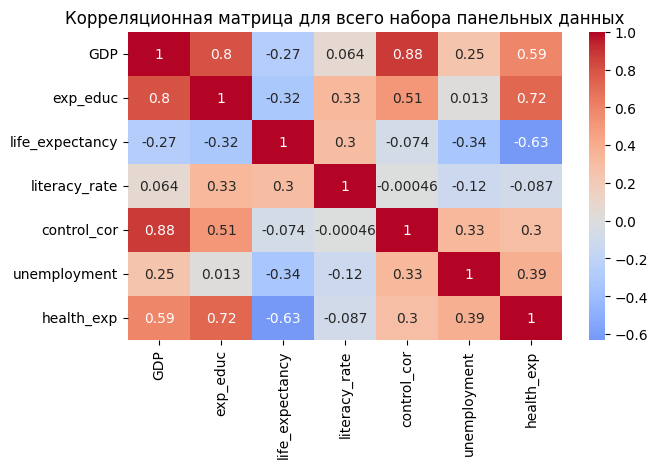

In [417]:
corr_matrix = df_pivot.corr()
plt.figure(figsize = (7, 4))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Корреляционная матрица для всего набора панельных данных')
plt.show();

Видим сильную положительную корреляцию между борьбой с коррупцией и ВВП, также расходы на здравоохранение сильно коррелирует с несколькими показателями, поэтому можно пренебречь ими(control_cor, health_exp).
Также можем заметить, что другие показатели относительно одинаково влиют на продолжительность жизни.

In [418]:
df_pivot.drop(['control_cor','health_exp'],axis=1,inplace=True)
vif = [variance_inflation_factor(df_pivot.corr().values, i) for i in range(df_pivot.corr().shape[1])]
for i, j in enumerate(vif):
  print(df_pivot.columns[i], j)

GDP 69.50955901626199
exp_educ 101.74572057120717
life_expectancy 11.55464735386939
literacy_rate 11.39235472252474
unemployment 6.981183541501419


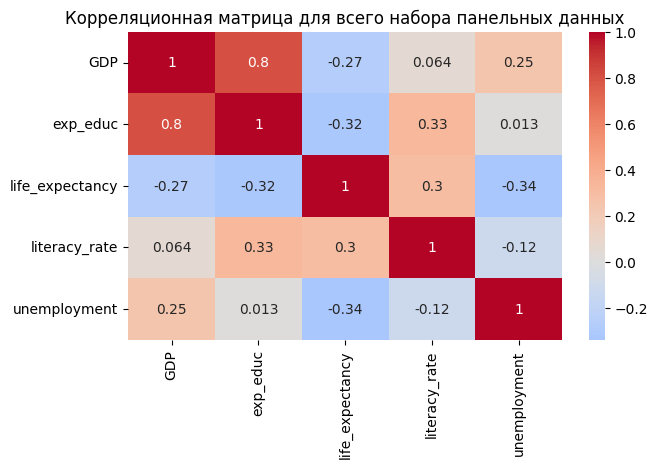

In [419]:
corr_matrix = df_pivot.corr()
plt.figure(figsize = (7, 4))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Корреляционная матрица для всего набора панельных данных')
plt.show();

In [420]:
df_pivot.drop(['GDP'],axis=1,inplace=True)
vif = [variance_inflation_factor(df_pivot.corr().values, i) for i in range(df_pivot.corr().shape[1])]
for i, j in enumerate(vif):
  print(df_pivot.columns[i], j)

exp_educ 3.84327755775688
life_expectancy 4.82767617482015
literacy_rate 3.577432944473826
unemployment 1.723824029359981


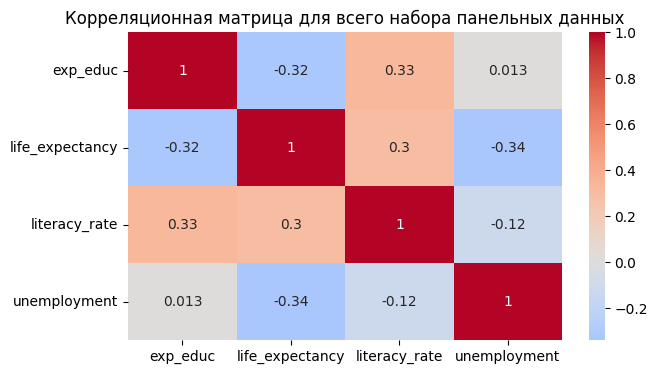

In [421]:
corr_matrix = df_pivot.corr()
plt.figure(figsize = (7, 4))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Корреляционная матрица для всего набора панельных данных')
plt.show();

#**Построение моделей**

**Модель пула**

Построение модели без переменных 'control_cor',  'health_exp', 'GDP'

In [422]:
df_pivot = df_pivot.reset_index()
df_pivot['Year'] = df_pivot['Year'].astype(int)
df_pivot.set_index(['Country', 'Year'], inplace = True)
x = ['exp_educ','literacy_rate','unemployment']
X = sm.add_constant(df_pivot[x])
y = df_pivot['life_expectancy']

In [423]:
pooled_model = PanelOLS(y, X, entity_effects = False, time_effects = False)
pooled_model = pooled_model.fit(cov_type = 'clustered', cluster_entity = True)
print(pooled_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.3696
Estimator:                   PanelOLS   R-squared (Between):              0.7446
No. Observations:                  73   R-squared (Within):               0.0766
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.3696
Time:                        19:02:32   Log-likelihood                   -181.20
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      13.483
Entities:                           5   P-value                           0.0000
Avg Obs:                       14.600   Distribution:                    F(3,69)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             5.2188
                            

Константа не является статистически значимой. Переменная "exp_educ" является статистически значимым и имеет отрицательный коэффициент. Это указывает на то, что увеличение расходов на обучение приводит к уменьшению продолжительности жизни. Переменная "literacy_rate" положительно сказывается на продолжительность жизни. Переменная 'unemployment' является статистически значимой и отрицательно влияет на продолжительность жинзи

Построение модели пула без переменных 'GDP', 'exp_educ'

In [442]:
df_pivot.drop(['GDP','exp_educ'],axis=1,inplace=True)
vif = [variance_inflation_factor(df_pivot.corr().values, i) for i in range(df_pivot.corr().shape[1])]
for i, j in enumerate(vif):
  print(df_pivot.columns[i], j)

life_expectancy 8.757606843510105
literacy_rate 1.6900271466387453
control_cor 2.1841797464492916
unemployment 2.6356143281195195
health_exp 8.815338108704704


FIV тест показал, что без переменных 'GDP' и 'exp_educ' отсутствует коллинеарность

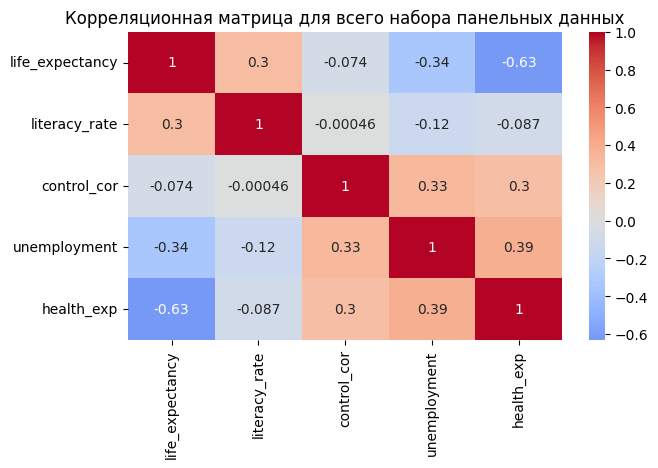

In [443]:
corr_matrix = df_pivot.corr()
plt.figure(figsize = (7, 4))
sns.heatmap(corr_matrix, annot = True, cmap = 'coolwarm', center = 0)
plt.title('Корреляционная матрица для всего набора панельных данных')
plt.show();

In [444]:
df_pivot = df_pivot.reset_index()
df_pivot['Year'] = df_pivot['Year'].astype(int)
df_pivot.set_index(['Country', 'Year'], inplace = True)
x = ['control_cor','literacy_rate','unemployment','health_exp']
X = sm.add_constant(df_pivot[x])
y = df_pivot['life_expectancy']

In [445]:
pooled_model = PanelOLS(y, X, entity_effects = False, time_effects = False)
pooled_model = pooled_model.fit(cov_type = 'clustered', cluster_entity = True)
print(pooled_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.4828
Estimator:                   PanelOLS   R-squared (Between):              0.9716
No. Observations:                  73   R-squared (Within):               0.1024
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.4828
Time:                        19:05:29   Log-likelihood                   -173.97
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.868
Entities:                           5   P-value                           0.0000
Avg Obs:                       14.600   Distribution:                    F(4,68)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             323.54
                            

Если мы сравним две эти модели пула, то модель без переменных 'GDP' и "exp_educ" является лучше, так как значение R-квадрат больше. Первая модель пула объясняет 36.9% вариаций зависимой переменной, в то время как вторая модель - 48.2%

Все коэффициенты в этой модели являются статстически значимыми за исключением коэффициента переменной 'unemployment'

Спецификация модели:    
$y = 6.7126 + 0.1345X_1+0.3295X_2-0.2343X_4$

control_cor - $X_1$    
literacy_rate - $X_2$    
unemployment - $X_3$    
health_exp - $X_4$     

#**Модель с фиксированными эффектами**

In [446]:
fix_model = PanelOLS(y, X, entity_effects = True).fit()
print(fix_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.1269
Estimator:                   PanelOLS   R-squared (Between):              0.7681
No. Observations:                  73   R-squared (Within):               0.1269
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.4046
Time:                        19:05:42   Log-likelihood                   -172.02
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      2.3253
Entities:                           5   P-value                           0.0658
Avg Obs:                       14.600   Distribution:                    F(4,64)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             2.3253
                            

Для этой модели все коэффициенты не значимы. Это может указывать на неправильный подбор стран. Попробуем построить модель без данных Франции и Германии

In [447]:
new_df = df_pivot.drop(['France','Germany'], level='Country')

In [455]:
x = ['control_cor','literacy_rate','unemployment','health_exp']
X = sm.add_constant(new_df[x])
y = new_df['life_expectancy']

**Модель пула без данных Франции и Германии**

In [449]:
pooled_model = PanelOLS(y, X, entity_effects = False, time_effects = False)
pooled_model = pooled_model.fit(cov_type = 'clustered', cluster_entity = True)
print(pooled_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.6251
Estimator:                   PanelOLS   R-squared (Between):              0.9974
No. Observations:                  43   R-squared (Within):               0.2323
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.6251
Time:                        19:05:45   Log-likelihood                   -97.138
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      15.837
Entities:                           3   P-value                           0.0000
Avg Obs:                       14.333   Distribution:                    F(4,38)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):          8.047e+14
                            

Спецификация модели:    
$y = 9.8371 + 0.1049X_1+0.3089X_2-0.5945X_3-0.2119X_4 + \epsilon_{it}$

control_cor - $X_1$    
literacy_rate - $X_2$    
unemployment - $X_3$    
health_exp - $X_4$

После удаления, коэффициент unemployment стал значимым

**Модель с фиксированными эффектами после удаления данных Франции и Германии**

In [450]:
fix_model = PanelOLS(y, X, entity_effects = True).fit()
print(fix_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.2633
Estimator:                   PanelOLS   R-squared (Between):              0.5557
No. Observations:                  43   R-squared (Within):               0.2633
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.4128
Time:                        19:05:48   Log-likelihood                   -96.173
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      3.2161
Entities:                           3   P-value                           0.0235
Avg Obs:                       14.333   Distribution:                    F(4,36)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             3.2161
                            

Коэффициенты остались незначимыми, кроме unemployment

Спецификация модели:    
$y = -0.6369X_3+\epsilon_{it}$

**Модель со случайными эффектами**

In [456]:
random_effect_model = PanelOLS(y, X, entity_effects = True, time_effects = True).fit()
print(random_effect_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.4510
Estimator:                   PanelOLS   R-squared (Between):              0.8771
No. Observations:                  43   R-squared (Within):               0.2243
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.5579
Time:                        19:06:55   Log-likelihood                   -68.203
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      4.5182
Entities:                           3   P-value                           0.0081
Avg Obs:                       14.333   Distribution:                    F(4,22)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             4.5182
                            

Все коэффициенты незначимы.



In [452]:
x = ['control_cor','literacy_rate','unemployment']
X = sm.add_constant(new_df[x])
y = new_df['life_expectancy']
random_effect_model = PanelOLS(y, X, entity_effects = True, time_effects = True).fit()
print(random_effect_model)

                          PanelOLS Estimation Summary                           
Dep. Variable:        life_expectancy   R-squared:                        0.4244
Estimator:                   PanelOLS   R-squared (Between):              0.4081
No. Observations:                  43   R-squared (Within):               0.1095
Date:                Mon, Jun 03 2024   R-squared (Overall):              0.2631
Time:                        19:05:53   Log-likelihood                   -69.220
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      5.6530
Entities:                           3   P-value                           0.0047
Avg Obs:                       14.333   Distribution:                    F(3,23)
Min Obs:                       14.000                                           
Max Obs:                       15.000   F-statistic (robust):             5.6530
                            

Я построил модель без переменной 'health_exp', вследтсвии чего коэффициент unemployment стал значимым    


Спецификация модели:    
$y = -0.9473X_3+\epsilon_{it}$

#**Выбор модели**

In [460]:
def hausman_test(fix_model, random_effect_model):
    fix_params = fix_model.params
    random_effect_params = random_effect_model.params

    diff_params = fix_params - random_effect_params
    vcov_fe = fix_model.cov
    vcov_diff = vcov_fe - random_effect_model.cov

    test_stat = diff_params.dot(np.linalg.inv(vcov_diff)).dot(diff_params)
    chi_krit = chi2.ppf(0.95, len(b_diff))
    print(f'статистика Хаусмана = {test_stat:.3f}')
    print(f'критическое chi2 = {chi_krit:.3f}')
    if test_stat > chi_krit:
        print('Модель с фиксированными эффектами')
    else:
        print('Модель со случайными эффектами')

# Сравнение моделей
hausman_test(fix_model, random_effect_model)

статистика Хаусмана = 2.539
критическое chi2 = 9.488
Модель со случайными эффектами


Теперь сравним модель со случайныим эффектмами с моделью пула

In [478]:
from linearmodels.panel import compare
print(compare({'Pooled OLS': pooled_model,'Random effects': random_effect_model}))

                        Model Comparison                       
                                 Pooled OLS      Random effects
---------------------------------------------------------------
Dep. Variable               life_expectancy     life_expectancy
Estimator                          PanelOLS            PanelOLS
No. Observations                         43                  43
Cov. Est.                         Clustered          Unadjusted
R-squared                            0.6251              0.4510
R-Squared (Within)                   0.2323              0.2243
R-Squared (Between)                  0.9974              0.8771
R-Squared (Overall)                  0.6251              0.5579
F-statistic                          15.837              4.5182
P-value (F-stat)                     0.0000              0.0081
=====================     =================   =================
const                                9.8371              16.560
                                   (9.06

In [479]:
LM = N*T/(2*(T-1)) * (sum(pooled_model.resids)**2 / pooled_model.resid_ss - 1)**2
print(f'LM = {LM:.3f}')
if LM > 3.84:  # при 0.05% уровне значимости хи2 распределение с 1 степенью свободы
  print('есть индивидуальные эффекты ')
else:
  print('объединенная модель')

LM = 21.429
есть индивидуальные эффекты 


#**Сравнение моделей**

Таким образом, после исследования трех рахных моделей для панельных данных и последующего сравнения, можно сделать вывод, что модель со случайными эффектами является лучшей моделью. Это подтверждается статистикой Хаусмана, а также, при проведения теста Бройша-Пагана, нулевая гипотеза отвергается, что значит, что модель со случайными эффектами подходит больше всего    

Однако хочу заметить, что для модели пула коэффициенты детерминации (внутригрупповой, межгрупповой, общий) выше, чем для модели со случайными эффектами, что может лучше объяснять вариацию зависимой переменной. Также спецификация модели пула имеет больше переменных.